## References
#### https://www.kaggle.com/code/thibauthurson/stock-price-prediction-with-lstm-multi-step-lstm
#### https://github.com/Hupperich-Manuel/LSTM-XGBoost-Hybrid-Forecasting/tree/a9dc8a86ea8af50f372394f7aa08bec2c56013f5

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json 
import os
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

In [37]:
# Importing data
df = pd.read_csv('open/train.csv')
df.head()

,일자,종목코드,종목명,거래량,시가,고가,저가,종가
0,20210601,A060310,3S,166690,2890,2970,2885,2920
1,20210601,A095570,AJ네트웍스,63836,5860,5940,5750,5780
2,20210601,A006840,AK홀딩스,103691,35500,35600,34150,34400
3,20210601,A054620,APS,462544,14600,14950,13800,14950
4,20210601,A265520,AP시스템,131987,29150,29150,28800,29050


In [69]:
company = 'AJ네트웍스'
df = df[df['종목명'] == 'AJ네트웍스']

In [39]:
df.shape #494 days with 8 features

(494, 8)

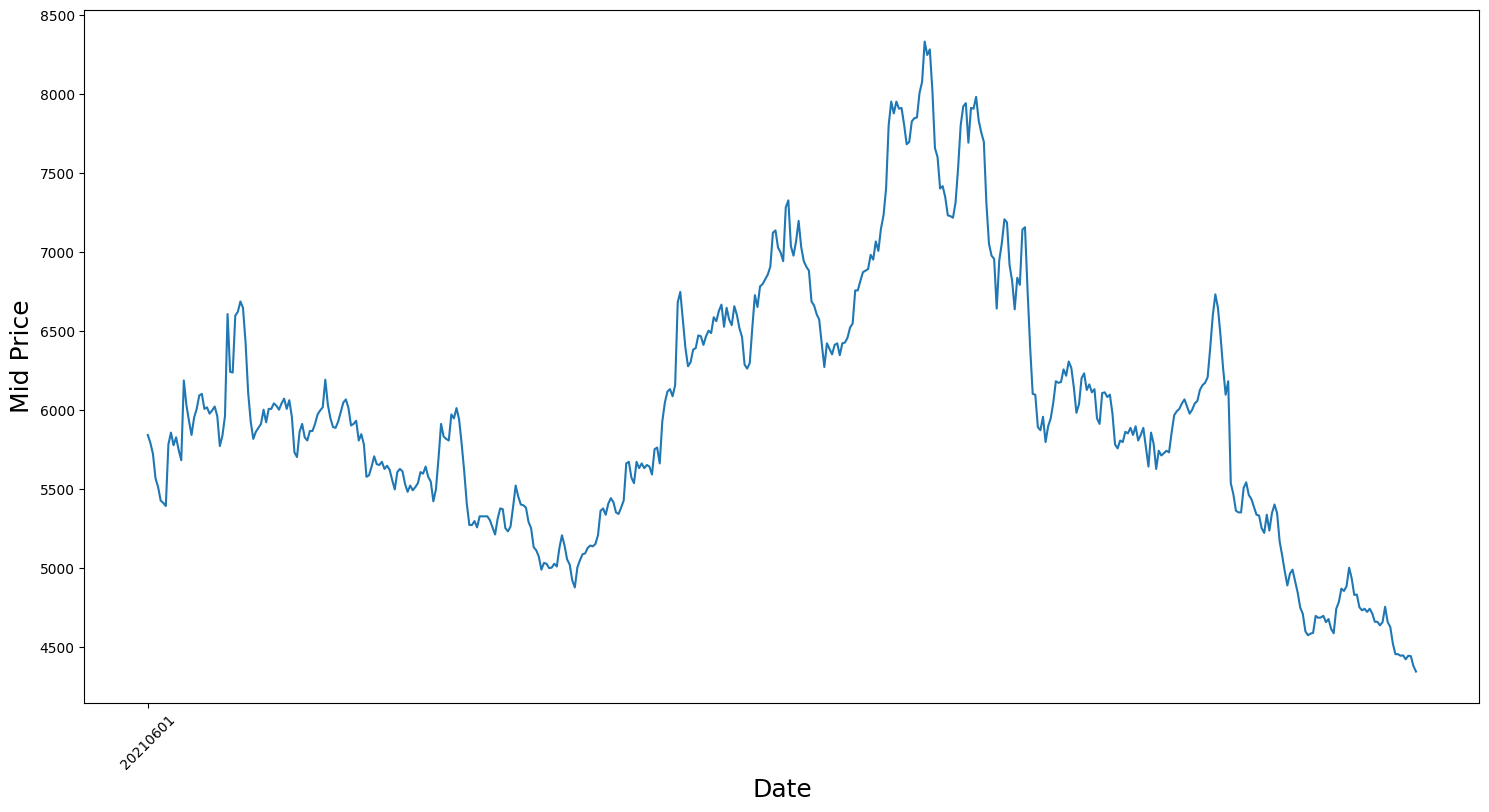

In [40]:
plt.figure(figsize = (18,9))
plt.plot(range(df[:500].shape[0]),(df[:500]['저가']+df[:500]['고가'])/2.0)
plt.xticks(range(0,df[:500].shape[0],500),df[:500]['일자'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Text(0.5, 1.0, 'Tesla stock closing price')

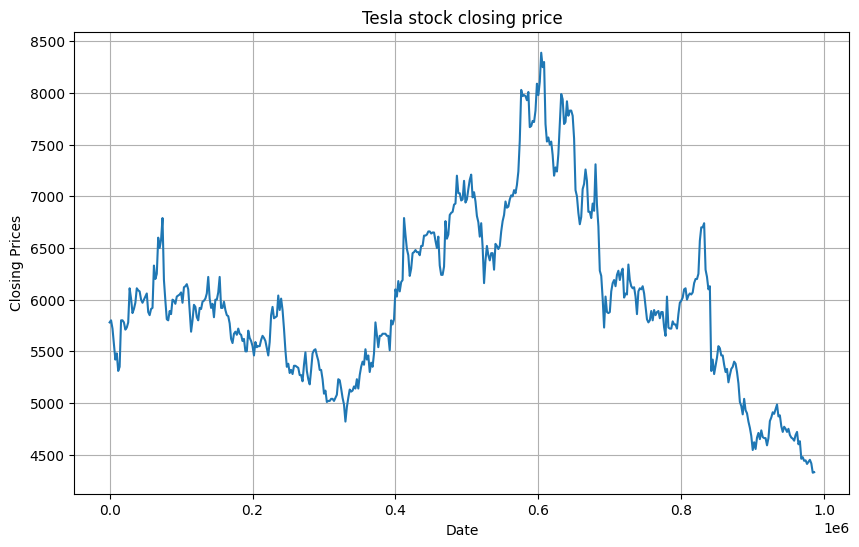

In [41]:
# Plot closing prices
df_close = df['종가']

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Tesla stock closing price')

In [42]:
# Stationary Point: static mean & variance
# Reference: https://www.kaggle.com/code/thibauthurson/stock-price-prediction-with-lstm-multi-step-lstm
def test_stationarity(timeseries):    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

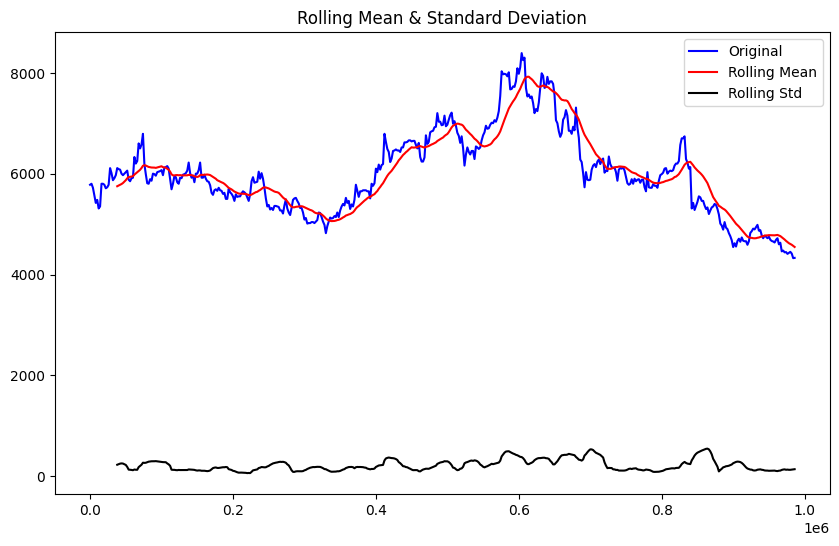

Results of Dickey-Fuller Test:
Test Statistic                  -1.356810
p-value                          0.602798
#Lags Used                       0.000000
Number of Observations Used    493.000000
Critical Value (1%)             -3.443684
Critical Value (5%)             -2.867420
Critical Value (10%)            -2.569902
dtype: float64


In [43]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

As p-value greater than 5% critical value, null hypothesis cannot be rejected
-> Time series is not stationary

C:\ProgramData\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.tight_layout()
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\statsmodels\tsa\seasonal.py:338: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.tight_layout()
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  func(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


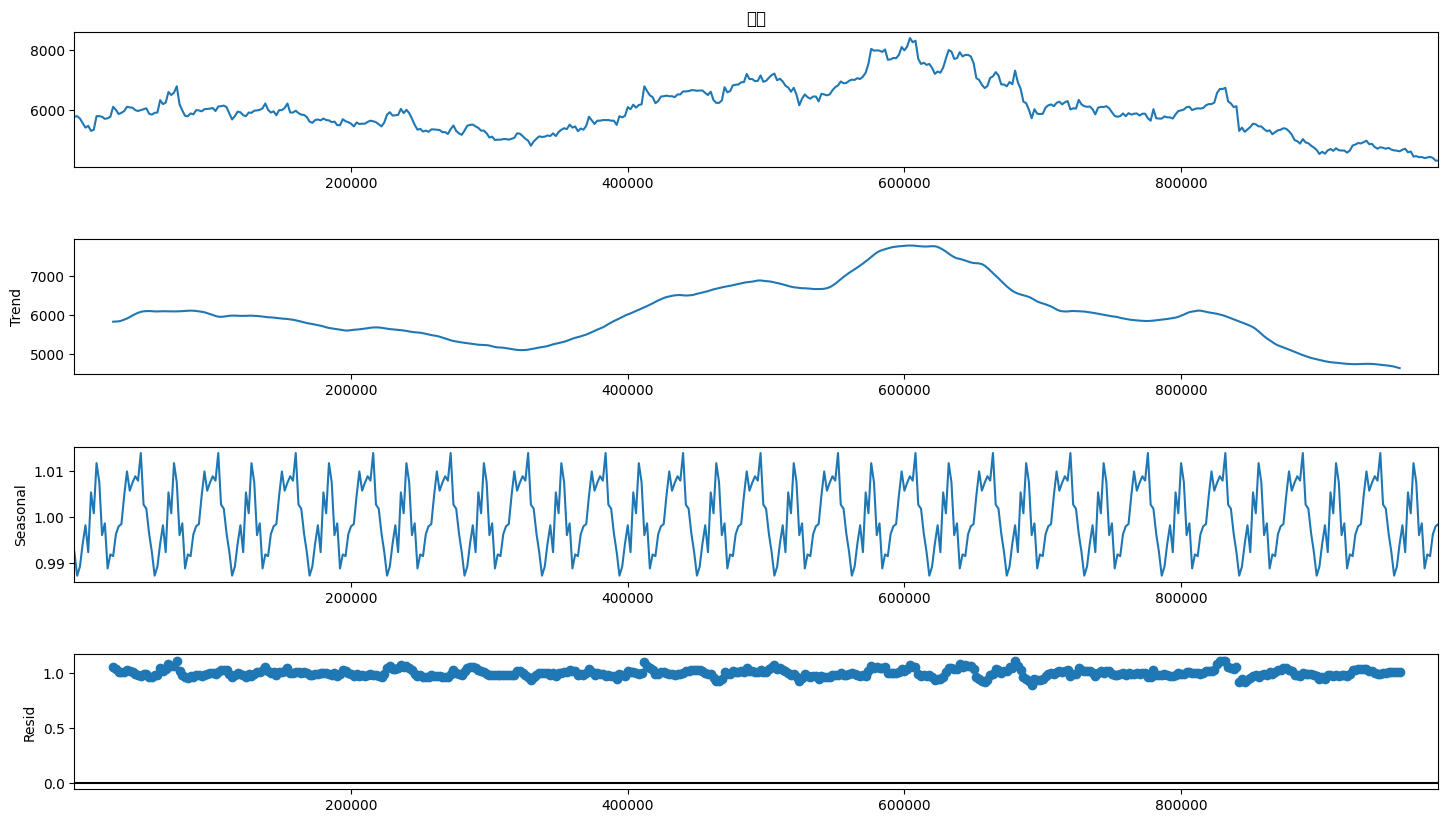

In [44]:
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)
# estimating & eliminating trends -> time series is constantly increasing. so apply log transform 

Text(0.5, 1.0, 'Transformed data')

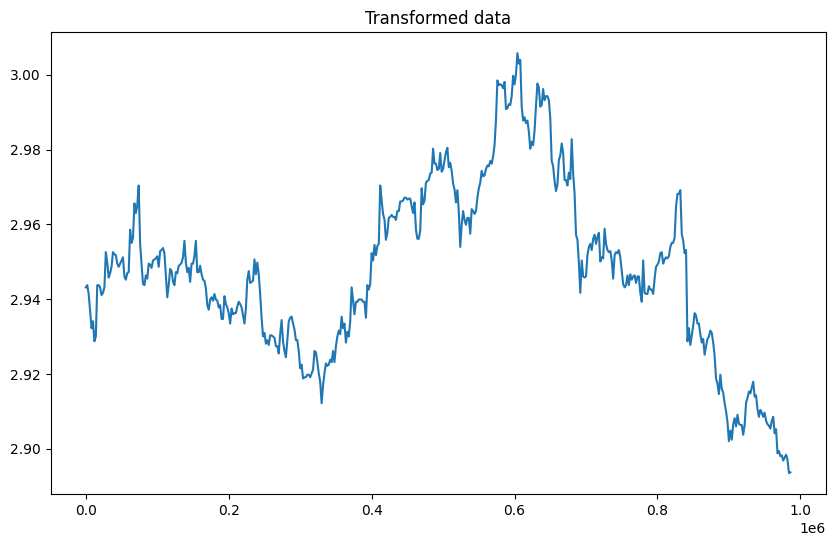

In [46]:
# To deal with trend and seasonality: differentiating
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

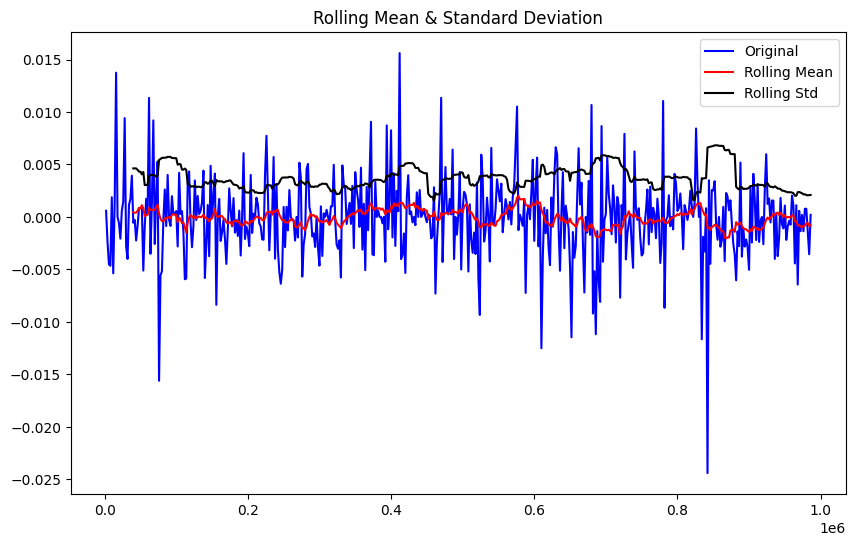

Results of Dickey-Fuller Test:
Test Statistic                 -22.776554
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    492.000000
Critical Value (1%)             -3.443711
Critical Value (5%)             -2.867432
Critical Value (10%)            -2.569908
dtype: float64


In [47]:
# Now this becomes stationary series with p-value less than 5% threshold -> null hypothesis rejected
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [11]:
# Pre-processing
trainig_set= aapl_data.iloc[:1530,:].values
test_set= aapl_data.iloc[1530:,:].values
sc= MinMaxScaler(feature_range=(0,1))
sc.fit(trainig_set)
trainig_set_scaled= sc.transform(trainig_set)
testing_set_scaled= sc.transform(test_set)

In [15]:
trainig_set_scaled.shape

(1530, 1)

# LSTM

### Data needs to be processed to pass to an LSTM model
#### Training data: [samples, timesteps, features] (if feature=1, univariate)

In [ ]:
# For multi-step (sliding window)
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    
    return X, y

In [48]:
# In order to get the specific days from the data
def preprocess_lstm(shifts, n_steps, n_features):
    X, y = [], []
    for i in range(len(shifts)):
        # find the end of this pattern
        end = i + n_steps
        # check if we are beyond the sequence
        if end >= len(shifts):
            break
        # gather input and output parts of the pattern
        X_shift, y_shift = shifts[i:end], shifts[end]
        X.append(X_shift)
        y.append(y_shift)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [60]:
num_days = 365
n_features = 1
X, y = preprocess_lstm(df_close_shift.to_numpy(), num_days, n_features) #(493, 365, 1)

In [84]:
df_close_shift.shape

(493,)

In [82]:
X.shape

(128, 365, 1)

In [61]:
#Split the data set between the training set and the test set
test_days = 15 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

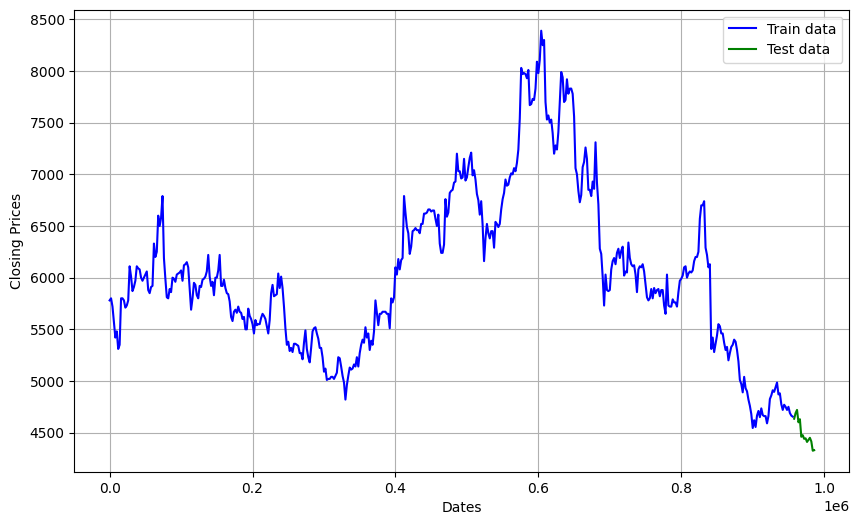

In [62]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [ ]:
* DACON
* 본선 -> 데이터 x (외국인 보유량) -> prediction
시계열 -> prediction (그 날의 외국인 보유량)
* 외국인 보유량 ->  예측값 -> feature -> 주가 예측 [feature]
* 가격


In [8]:
# Create a data structure with 60 timesteps and 1 output
X_train=[] #Independent variables
y_train= [] # Dependent variables 
# I am going to append past 60 days data 
for i in range(60,1530):
    X_train.append(trainig_set_scaled[i-60:i,0]) # Appending prevois 60 days data not including 60
    y_train.append(trainig_set_scaled[i,0])
    
X_train, y_train= np.array(X_train), np.array(y_train)

In [9]:
# Input & Ouput 
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
train_inputs, train_outputs = [],[]

# You unroll the input over time defining placeholders for each time step
for ui in range(num_unrollings):
    train_inputs.append(tf.placeholder(tf.float32, shape=[batch_size,D],name='train_inputs_%d'%ui))
    train_outputs.append(tf.placeholder(tf.float32, shape=[batch_size,1], name = 'train_outputs_%d'%ui))


Instructions for updating:
non-resource variables are not supported in the long term


NameError: name 'num_unrollings' is not defined

In [64]:
# Importing the Keras libraries and packages
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

tf.random.set_seed(40)

#  Initialising the RNN
model= Sequential()

# Adding first LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True, input_shape=(num_days, n_features)))
model.add(Dropout(rate=0.2))

# Adding second LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding third LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding fourth LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100,return_sequences=True))
model.add(Dropout(rate=0.2))

# Adding fifth LSTM layer and some dropout Dropout regularisation
model.add(LSTM(units=100))
model.add(Dropout(rate=0.2))

# Adding the Output Layer
model.add(Dense(units=1))

# Compiling the Model
# Because we're doing regression hence mean_squared_error
#opt = Adam(learning_rate=0.05)
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.05), metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [65]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 365, 100)          40800     
                                                                 
 dropout_5 (Dropout)         (None, 365, 100)          0         
                                                                 
 lstm_6 (LSTM)               (None, 365, 100)          80400     
                                                                 
 dropout_6 (Dropout)         (None, 365, 100)          0         
                                                                 
 lstm_7 (LSTM)               (None, 365, 100)          80400     
                                                                 
 dropout_7 (Dropout)         (None, 365, 100)          0         
                                                                 
 lstm_8 (LSTM)               (None, 365, 100)         

In [66]:
model.fit(X_train, y_train, epochs=15, batch_size = 32)

Train on 113 samples
Epoch 1/15
113/113 [==============================] - 5s 46ms/sample - loss: 2.5598 - mean_absolute_error: 1.1608
Epoch 2/15
113/113 [==============================] - 4s 34ms/sample - loss: 0.8863 - mean_absolute_error: 0.8974
Epoch 3/15
113/113 [==============================] - 4s 38ms/sample - loss: 0.0186 - mean_absolute_error: 0.1115
Epoch 4/15
113/113 [==============================] - 4s 38ms/sample - loss: 0.0168 - mean_absolute_error: 0.1225
Epoch 5/15
113/113 [==============================] - 4s 37ms/sample - loss: 0.0056 - mean_absolute_error: 0.0716
Epoch 6/15
113/113 [==============================] - 4s 35ms/sample - loss: 0.0032 - mean_absolute_error: 0.0538
Epoch 7/15
113/113 [==============================] - 4s 37ms/sample - loss: 0.0015 - mean_absolute_error: 0.0365
Epoch 8/15
113/113 [==============================] - 4s 34ms/sample - loss: 2.9528e-04 - mean_absolute_error: 0.0148
Epoch 9/15
113/113 [==============================] - 4s 37ms/s

In [67]:
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data


C:\ProgramData\anaconda3\envs\stock\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Test MSE: 2.7074436729890294e-05
Test MAE: 0.0046788706


C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 45348 (\N{HANGUL SYLLABLE NE}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 50893 (\N{HANGUL SYLLABLE WEOG}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  func(*args, **kwargs)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45348 (\N{HANGUL SYLLABLE NE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\ProgramData\anaconda3\envs\stock\lib\site-packages\IPython\c

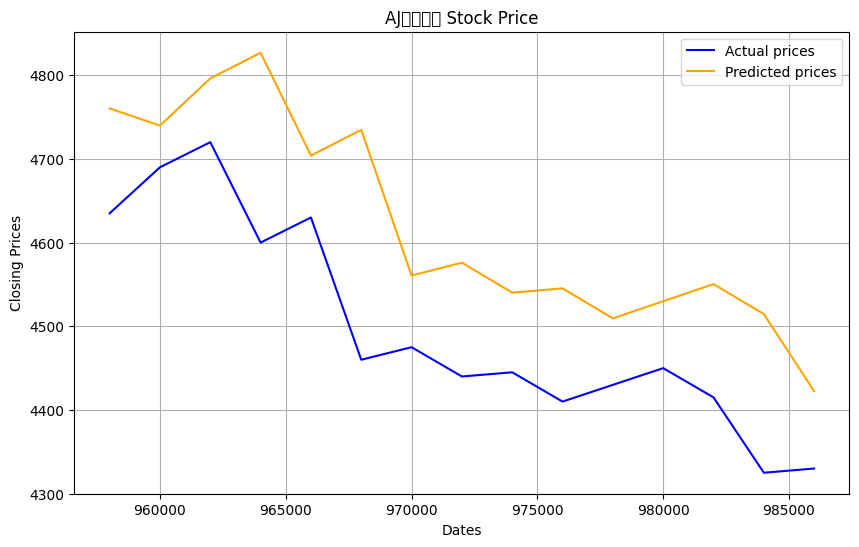

In [70]:
# Prediction
y_pred = model.predict(X_test)

# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:] 

# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)


# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

In [35]:
# Hyperparameters
D = 1 # Dimensionality of the data -> can adapt by number of features
num_unrollings = 15 # Number of time steps you look into the future
batch_size = 20 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 


#Parameters for the LSTM
PERCENTAGE = .98 #Split train/val and test set
CALLBACK = .031 #Used to stop training the Network when the MAE from the validation set reached a perormance below 3.1%
BATCH_SIZE = 20 #Number of samples that will be propagated through the network. I chose almost a trading month
EPOCH = 50 #Settled to train the model
WINDOW_LSTM = 30 #The window used for the input data
PREDICTION_SCOPE = 0 #How many period to predict, being 0=1

# Resetting
tf.compat.v1.reset_default_graph() # This is important in case you run this multiple times

In [ ]:
# Predictions
data_total= pd.concat([trainig_set['종가'], test_set['종가']],  axis=0)
inputs= data_total[len(data_total)-len(test_set)-60:].values 
inputs = inputs.reshape(-1,1) 
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 230):
    X_test.append(inputs[i-60:i, 0])

X_test = np.array(X_test)
# 3D format
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)


# Different Repo -> using sliding window
last_df = train_lstm.iloc[-61:,:].values[np.newaxis,...] 
lstm_pred = model.predict(last_df)

lstm_pred = lstm_pred.reshape(output_window,4)
lstm_pred = lstm_pred * size[:4].values + mini[:4].values
lstm_pred = lstm_pred.astype(int)
lstm_pred = lstm_pred[:31]
lstm_pred

# XGBoost

Need to set the feature before implementing -> What feature is important and relevant? \
Boosted gradient tree algorithm -> can get the similarity batween two features \
Repo: https://zephyrus1111.tistory.com/232

In [ ]:
from xgboost import XGBRegressor

## Convert the data into time-series
def date_to_values(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # 입력 sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # 출력 sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

## Fitting Model
def xgboost_forcasting(dataname, n_in_size):
    values = list(dataname.iloc[:,1].values)
    data = date_to_values(values, n_in = n_in_size)
    train_x, train_y = data[:,:-1], data[:,-1]
    xgboost = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
    xgboost.fit(train_x, train_y)
    return train_x, xgboost

## 예측 함수
def xgb_prediction(data, data2, model_name, num1, num2, name):
    for i in range(0,num2):
        if i==0:
            first = np.reshape(data[-1], (1,num1))
            pred = model_name.predict(first)
            data2[name][i] = pred
            tt = np.reshape(np.append(data[-1,1:], pred), (1,num1))
        else:
            pred = model_name.predict(tt)
            data2[name][i] = pred
            tt = np.reshape(np.append(tt[-1,1:], pred), (1,num1))

In [87]:
X_train.shape #(113,365)
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [88]:
from xgboost import XGBRegressor
xgboost = XGBRegressor(objective='reg:squarederror', n_estimators=1000, random_state = 40)
xgboost.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=40, ...)

In [89]:
pred_val = xgboost.predict(X_test)

In [90]:
pred_val

array([ 1.2627011e-03, -1.1624631e-03,  8.8630168e-04,  5.0545624e-03,
       -9.3442723e-05, -5.9889711e-04,  1.3408321e-03,  4.2862003e-03,
        1.1844214e-03, -1.0852327e-03, -2.9491945e-04, -3.5385899e-03,
        6.2023976e-04, -7.2705222e-04,  1.1797838e-03], dtype=float32)

In [96]:
from sklearn.metrics import mean_absolute_error
xg_mae = mean_absolute_error(y_test, pred_val)
xg_mae #smaller the better

0.0027203283849390005

# Ensemble: weighted sum

In [ ]:
### DateTime 인덱스 설정 -> repo
lstm_result.index = pd.to_datetime(lstm_result.index)
xgb_result.index = pd.to_datetime(xgb_result.index)
extra_result.index = pd.to_datetime(extra_result.index)

final_result = ((lstm_result*0.3)+(xgb_result*0.7))*0.2 + extra_result*0.8
final_result = final_result.astype(int)
final_result

In [104]:
lstm_mae = results[1]
sum_mae = lstm_mae + xg_mae
avg_mae = (sum_mae)/2
pred = y_pred.squeeze() * (1-lstm_mae/sum_mae) + pred_val * (1-xg_mae/sum_mae)

In [105]:
y_pred.shape
pred_val.shape

(15,)

In [106]:
y_test.shape
pred.shape

(15,)

In [108]:
final_mae = mean_absolute_error(y_test, pred)
final_mae

0.002990172081687259

In [ ]:
# XGBoost + LSTM (+Extra Tree*N)

# 종가 -> KNN (cluster) + PCA (feature) -> 1~2개 
# 시계열 -> prediction (15일 데이터) 그 전 15일
-> 가격: open/train.csv -> prediction.csv -> DACON 
    -> feature 여러 개 넣어보기 -> 
* 매도

코드 -> pred (종가 prediction) 종가 기준으로 계산해서 

# post-processing -> weight값 생각해보기

1.섹터 + train.csv 조인 -> p-value 발라내서 for-loop 돌리기 []
2. stationary -> 함수화 [세현]
3. 모델 -> 함수화 [세현]
4. post-processing -> 순위 weight -> weight의 적절한 값이 무엇일까? [선영]
5. test -> 실제랑 비교 (네이버에서 종가~)